# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional #I added Bidrectional just to experiment
from keras.utils import pad_sequences

In [17]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [18]:
#Load your data into a pandas dataframe here

df = pd.read_csv("household_power_clean.csv")

In [ ]:
#create your training and validation sets here

#assign size for data subset

subset_size = int(len(df) * 0.01) #only sing 1% of data per instructions


#take random data subset

subset = np.random.choice(df.index, size = subset_size, replace = False)
df_subset = df.loc[subset].sort_index()

#split data subset 80/20 for train/validation

split_idx = int(len(df_subset) * 0.8)
train_df = df_subset.iloc[:split_idx] #first 80% for training
val_df = df_subset.iloc[split_idx:] #last 20% for validation

# I randomized the data to get a better distribution of values in the training and validation sets


In [32]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [33]:
seq_arrays = []
seq_labs = []


In [34]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings

for i in range(len(train_df) - seq_length - ph):

    # Get the sequence of 30 GAP readings
    input_seq = train_df[feat_cols].iloc[i:i + seq_length].values
    
    # Get the GAP value at the predictive horizon 
    output_idx = i + seq_length + ph - 1
    output_val = train_df[feat_cols].iloc[output_idx].values[0]
    
    seq_arrays.append(input_seq)
    seq_labs.append(output_val)

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [23]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [24]:
seq_arrays.shape

(16358, 30, 1)

#### https://realpython.com/python-assert-statement/

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert statement is used to check if certain assumptions are true. Here, we are just checking that we have the correct shape for the array. This helps us find bugs or issues before they cause bigger problems later. 

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [25]:
# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = len(feat_cols)
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=50, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

c:\Users\fenn3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 3s - 82ms/step - loss: 1.2817 - mse: 1.2817 - val_loss: 1.4051 - val_mse: 1.4051
Epoch 2/100
32/32 - 1s - 34ms/step - loss: 1.1645 - mse: 1.1645 - val_loss: 1.3807 - val_mse: 1.3807
Epoch 3/100
32/32 - 1s - 34ms/step - loss: 1.1528 - mse: 1.1528 - val_loss: 1.3546 - val_mse: 1.3546
Epoch 4/100
32/32 - 1s - 34ms/step - loss: 1.1499 - mse: 1.1499 - val_loss: 1.3879 - val_mse: 1.3879
Epoch 5/100
32/32 - 1s - 34ms/step - loss: 1.1469 - mse: 1.1469 - val_loss: 1.3708 - val_mse: 1.3708
Epoch 6/100
32/32 - 1s - 33ms/step - loss: 1.1486 - mse: 1.1486 - val_loss: 1.3712 - val_mse: 1.3712
Epoch 7/100
32/32 - 1s - 34ms/step - loss: 1.1441 - mse: 1.1441 - val_loss: 1.3680 - val_mse: 1.3680
Epoch 8/100
32/32 - 1s - 33ms/step - loss: 1.1560 - mse: 1.1560 - val_loss: 1.4182 - val_mse: 1.4182
Epoch 9/100
32/32 - 1s - 33ms/step - loss: 1.1535 - mse: 1.1535 - val_loss: 1.3584 - val_mse: 1.3584
Epoch 10/100
32/32 - 1s - 34ms/step - loss: 1.1491 - mse: 1.1491 - val_loss: 1.4426 - 

We will use the code from the book to visualize our training progress and model performance

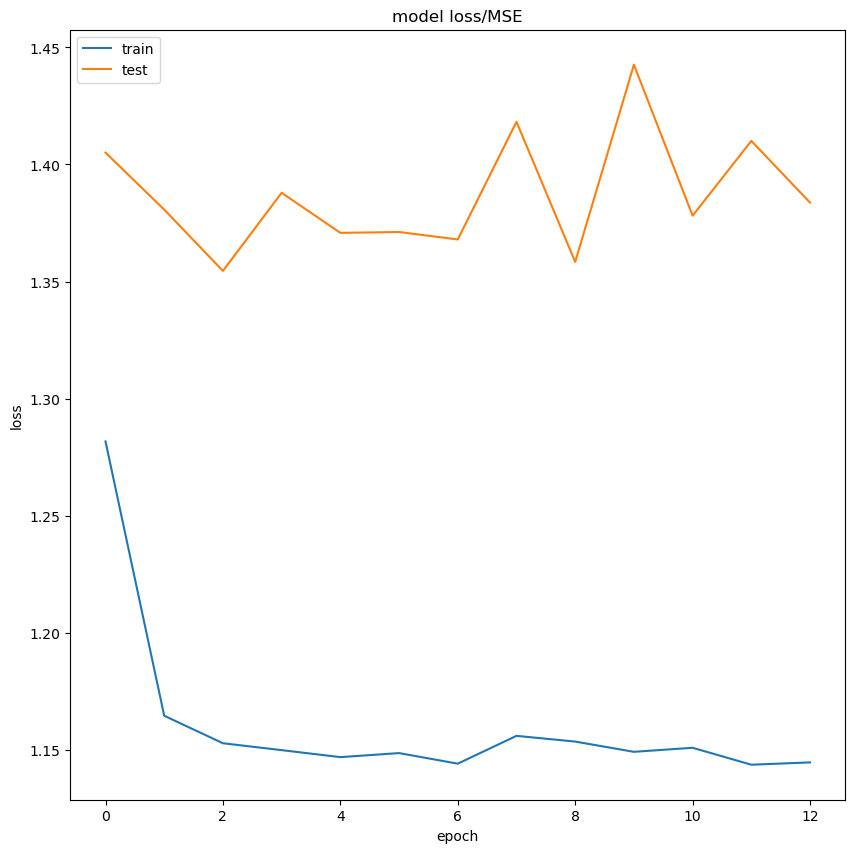

In [26]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


#### https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html

## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequence stacks tensors and pads them to equal length. The padding argument determines what value to use for padding. The default is 0, which makes sense for our use case since we are using an LSTM which already accounts for them.

In [27]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings

for i in range(1, len(val_df) - ph):
    # Get sequence starting from at least 2 readings, up to seq_length readings
    start_idx = max(0, i - seq_length + 1)
    val_seq = val_df[feat_cols].iloc[start_idx:i+1].values
    
    # Get the label at the predictive horizon
    if i + ph < len(val_df):
        label = val_df[feat_cols].iloc[i + ph].values[0]
        val_arrays.append(val_seq)
        val_labs.append(label)


# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding = "pre", dtype="float32")   
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

128/128 - 0s - 3ms/step - loss: 0.7783 - mse: 0.7783

MSE: 0.7782979607582092
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


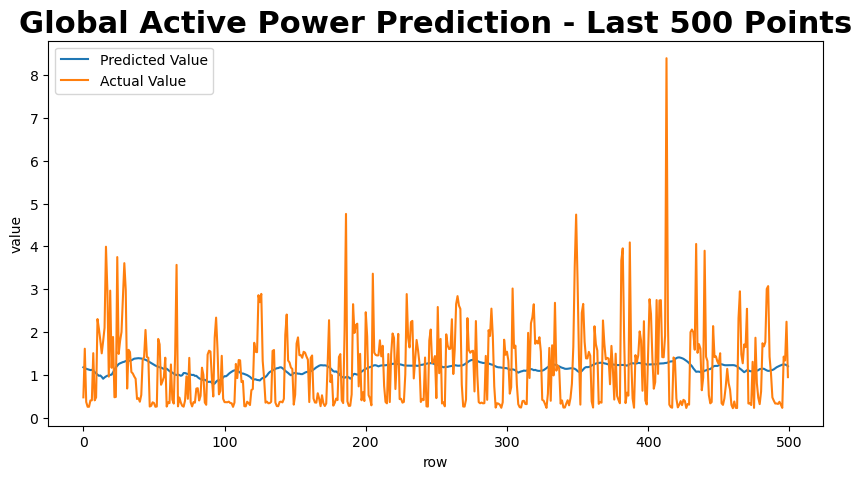

In [28]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: It appears that we have underfitting due to the variation in the orange or actual value and stability of the predicted or blue lines. We could improve the model by adding more layers, adding more neurons, or adding more features to the model.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: First I think I will add more features. Things like voltage might be useful. This will help since there are so many possible causes for changes in power usage. Next I think I will try to add more layers. This will help the model learn more complex patterns. I will also try to add more neurons to each layer. This will help the model learn more complex patterns. Finally I will try to add regularization. This will help prevent overfitting. 

Available columns in dataset:
['index', 'Unnamed: 0', 'Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Datetime', 'gap_monthly', 'grp_monthly', 'v_monthly', 'gi_monthly']
Improved training sequences shape: (16358, 30, 3)


c:\Users\fenn3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 30, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,353 (649.82 KB)

 Trainable params: 166,353 (649.82 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
61/61 - 6s - 93ms/step - loss: 1.2841 - mse: 1.2841 - val_loss: 1.4577 - val_mse: 1.4577
Epoch 2/100
61/61 - 4s - 57ms/step - loss: 1.2193 - mse: 1.2193 - val_loss: 1.5032 - val_mse: 1.5032
Epoch 3/100
61/61 - 4s - 57ms/step - loss: 1.2039 - mse: 1.2039 - val_loss: 1.4102 - val_mse: 1.4102
Epoch 4/100
61/61 - 4s - 58ms/step - loss: 1.1741 - mse: 1.1741 - val_loss: 1.3851 - val_mse: 1.3851
Epoch 5/100
61/61 - 4s - 58ms/step - loss: 1.1698 - mse: 1.1698 - val_loss: 1.3868 - val_mse: 1.3868
Epoch 6/100
61/61 - 4s - 58ms/step - loss: 1.1730 - mse: 1.1730 - val_loss: 1.3571 - val_mse: 1.3571
Epoch 7/100
61/61 - 4s - 57ms/step - loss: 1.1613 - mse: 1.1613 - val_loss: 1.4213 - val_mse: 1.4213
Epoch 8/100
61/61 - 3s - 57ms/step - loss: 1.1662 - mse: 1.1662 - val_loss: 1.3725 - val_mse: 1.3725
Epoch 9/100
61/61 - 3s - 56ms/step - loss: 1.1691 - mse: 1.1691 - val_loss: 1.3774 - val_mse: 1.3774
Epoch 10/100
61/61 - 3s - 56ms/step - loss: 1.1680 - mse: 1.1680 - val_loss: 1.4044 - 

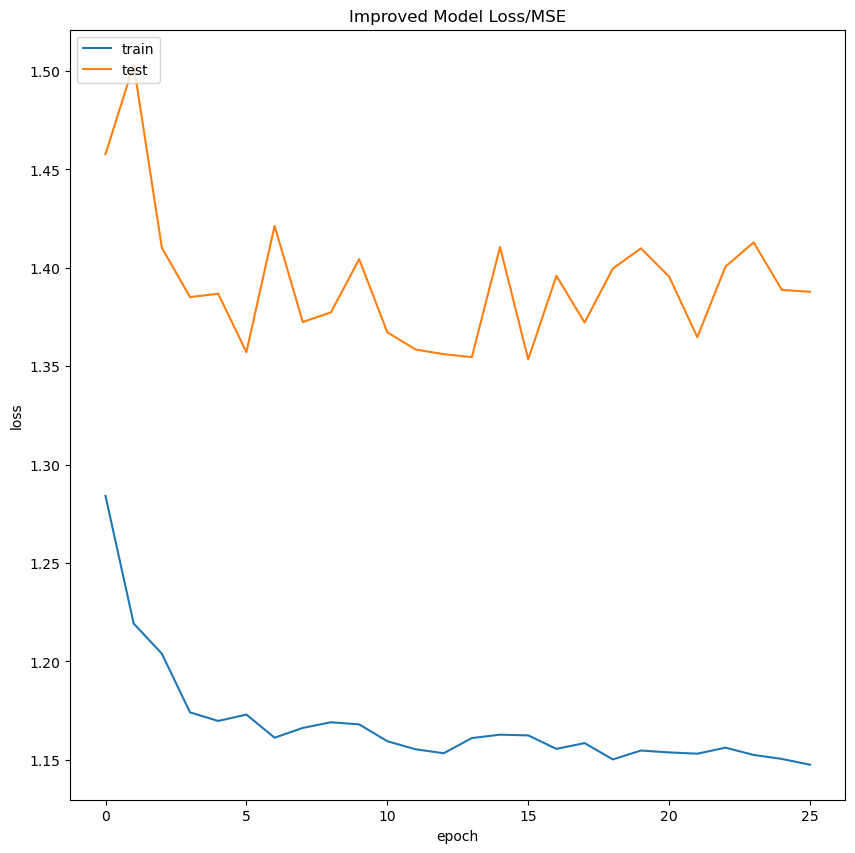

In [29]:
# Optimization Model 2: Improved architecture with more features and layers

# First, check what columns are available in the dataset
print("Available columns in dataset:")
print(train_df.columns.tolist())

# Use more features - add voltage and other relevant columns if available
feat_cols_improved = ["Global_active_power", "Voltage", "Global_intensity"]

# Rebuild training sequences with improved features
seq_arrays_v2 = []
seq_labs_v2 = []

for i in range(len(train_df) - seq_length - ph):
    # Get the sequence with multiple features
    input_seq = train_df[feat_cols_improved].iloc[i:i + seq_length].values
    
    # Get the GAP value at the predictive horizon (5 steps ahead)
    output_idx = i + seq_length + ph - 1
    output_val = train_df["Global_active_power"].iloc[output_idx]
    
    seq_arrays_v2.append(input_seq)
    seq_labs_v2.append(output_val)

# Convert to numpy arrays
seq_arrays_v2 = np.array(seq_arrays_v2, dtype=object).astype(np.float32)
seq_labs_v2 = np.array(seq_labs_v2, dtype=object).astype(np.float32)

print(f"Improved training sequences shape: {seq_arrays_v2.shape}")

# Build improved model with more layers and neurons
model_path_v2 = "LSTM_model2.keras"

nb_features_v2 = len(feat_cols_improved)
nb_out = 1

model_v2 = Sequential()

# Add first LSTM layer with more units
model_v2.add(LSTM(
         input_shape = (seq_length, nb_features_v2),
         units = 100, 
         return_sequences = True))
model_v2.add(Dropout(0.15)) 

# Add second LSTM layer with more units
model_v2.add(LSTM(
          units = 100,
          return_sequences = True))
model_v2.add(Dropout(0.15))

# Add third LSTM layer for more complexity
model_v2.add(LSTM(
          units = 64,
          return_sequences = False))
model_v2.add(Dropout(0.15))

# Add dense layers
model_v2.add(Dense(units = 32))
model_v2.add(Activation("relu"))
model_v2.add(Dropout(0.1))

model_v2.add(Dense(units = nb_out))
model_v2.add(Activation("linear"))

optimizer_v2 = keras.optimizers.Adam(learning_rate = 0.001)
model_v2.compile(loss = "mean_squared_error", optimizer = optimizer_v2, metrics = ["mse"])

print(model_v2.summary())

# Train the improved model
history_v2 = model_v2.fit(seq_arrays_v2, seq_labs_v2, epochs = 100, batch_size = 256, validation_split = 0.05, verbose = 2,
          callbacks = [keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 10, verbose = 0, mode = "min"),
                       keras.callbacks.ModelCheckpoint(model_path_v2, monitor = "val_loss", save_best_only = True, mode = "min", verbose = 0)]
          )

# Plot improved model loss curves
fig_loss_v2 = plt.figure(figsize = (10, 10))
plt.plot(history_v2.history["loss"])
plt.plot(history_v2.history["val_loss"])
plt.title("Improved Model Loss/MSE")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc = "upper left")
plt.show()
fig_loss_v2.savefig("LSTM_loss_improved.png")

# Normalize features 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))
train_df_scaled = train_df.copy()
train_df_scaled[feat_cols_improved] = scaler.fit_transform(train_df[feat_cols_improved])

val_df_scaled = val_df.copy()
val_df_scaled[feat_cols_improved] = scaler.transform(val_df[feat_cols_improved])


Model 3 training sequences shape: (16368, 20, 1)


c:\Users\fenn3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 2s - 75ms/step - loss: 1.3125 - mse: 1.3125 - val_loss: 1.4167 - val_mse: 1.4167
Epoch 2/100
32/32 - 1s - 26ms/step - loss: 1.1598 - mse: 1.1598 - val_loss: 1.4135 - val_mse: 1.4135
Epoch 3/100
32/32 - 1s - 26ms/step - loss: 1.1549 - mse: 1.1549 - val_loss: 1.4234 - val_mse: 1.4234
Epoch 4/100
32/32 - 1s - 26ms/step - loss: 1.1537 - mse: 1.1537 - val_loss: 1.3623 - val_mse: 1.3623
Epoch 5/100
32/32 - 1s - 26ms/step - loss: 1.1612 - mse: 1.1612 - val_loss: 1.3722 - val_mse: 1.3722
Epoch 6/100
32/32 - 1s - 25ms/step - loss: 1.1572 - mse: 1.1572 - val_loss: 1.4405 - val_mse: 1.4405
Epoch 7/100
32/32 - 1s - 25ms/step - loss: 1.1576 - mse: 1.1576 - val_loss: 1.4045 - val_mse: 1.4045
Epoch 8/100
32/32 - 1s - 26ms/step - loss: 1.1517 - mse: 1.1517 - val_loss: 1.4010 - val_mse: 1.4010
Epoch 9/100
32/32 - 1s - 25ms/step - loss: 1.1506 - mse: 1.1506 - val_loss: 1.3848 - val_mse: 1.3848
Epoch 10/100
32/32 - 1s - 25ms/step - loss: 1.1491 - mse: 1.1491 - val_loss: 1.3868 - 

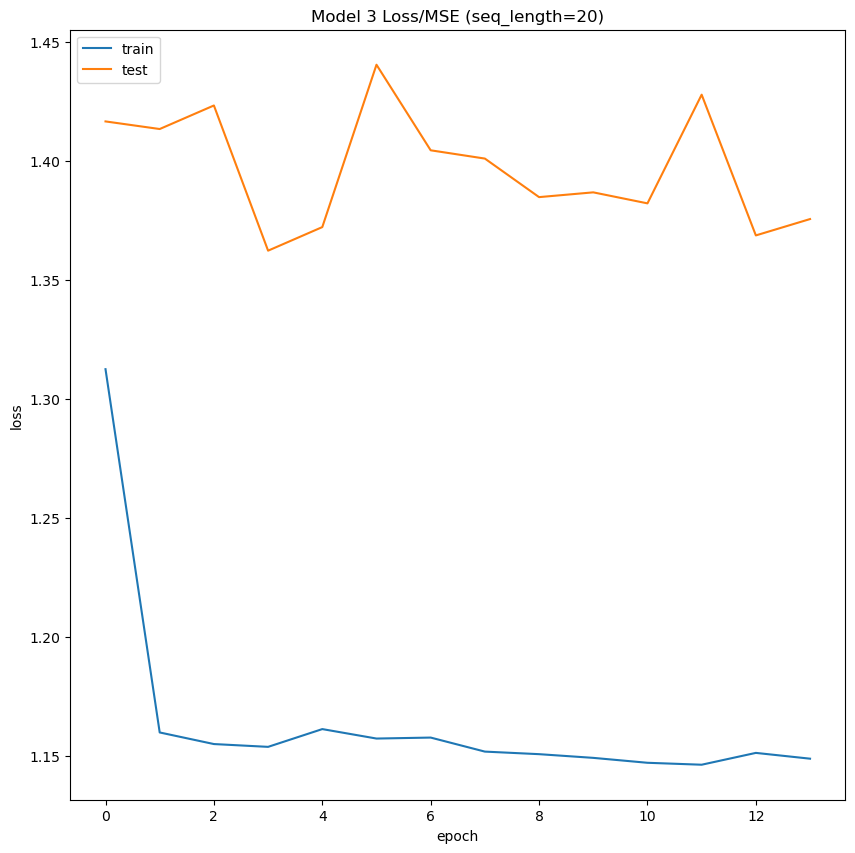

In [30]:
# Optimization Model 3: Same as Model 1 but with seq_length=20

seq_length_v3 = 20
ph_v3 = 5

feat_cols_v3 = ['Global_active_power']

# Build training sequences with shorter sequence length
seq_arrays_v3 = []
seq_labs_v3 = []

for i in range(len(train_df) - seq_length_v3 - ph_v3):
    input_seq = train_df[feat_cols_v3].iloc[i:i + seq_length_v3].values
    output_idx = i + seq_length_v3 + ph_v3 - 1
    output_val = train_df['Global_active_power'].iloc[output_idx]
    seq_arrays_v3.append(input_seq)
    seq_labs_v3.append(output_val)

seq_arrays_v3 = np.array(seq_arrays_v3, dtype=object).astype(np.float32)
seq_labs_v3 = np.array(seq_labs_v3, dtype=object).astype(np.float32)

print(f"Model 3 training sequences shape: {seq_arrays_v3.shape}")

# Build Model 3 - same architecture as Model 1 but with seq_length=20
model_path_v3 = 'LSTM_model3.keras'

nb_features_v3 = len(feat_cols_v3)

model_v3 = Sequential()

model_v3.add(LSTM(
         input_shape=(seq_length_v3, nb_features_v3),
         units=50,
         return_sequences=True))
model_v3.add(Dropout(0.2))

model_v3.add(LSTM(
          units=50,
          return_sequences=False))
model_v3.add(Dropout(0.2))
model_v3.add(Dense(units=1))
model_v3.add(Activation('linear'))

optimizer_v3 = keras.optimizers.Adam(learning_rate=0.01)
model_v3.compile(loss='mean_squared_error', optimizer=optimizer_v3, metrics=['mse'])

print(model_v3.summary())

# Train Model 3
history_v3 = model_v3.fit(seq_arrays_v3, seq_labs_v3, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                     keras.callbacks.ModelCheckpoint(model_path_v3, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

print(history_v3.history.keys())

# Plot Model 3 loss curves
fig_loss_v3 = plt.figure(figsize=(10, 10))
plt.plot(history_v3.history['loss'])
plt.plot(history_v3.history['val_loss'])
plt.title('Model 3 Loss/MSE (seq_length=20)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_loss_v3.savefig("LSTM_loss_model3.png")

Model 1 (Original - Single Feature, seq=30) Results:
128/128 - 0s - 3ms/step - loss: 0.7783 - mse: 0.7783
MSE: 0.778298
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


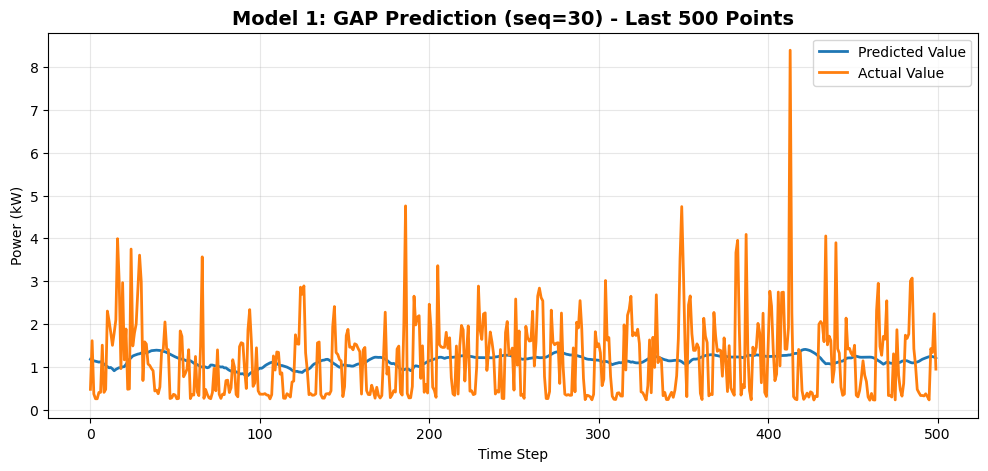


Model 2 (Improved - Multiple Features, seq=30) Results:
128/128 - 1s - 6ms/step - loss: 0.7770 - mse: 0.7770
MSE: 0.776994
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


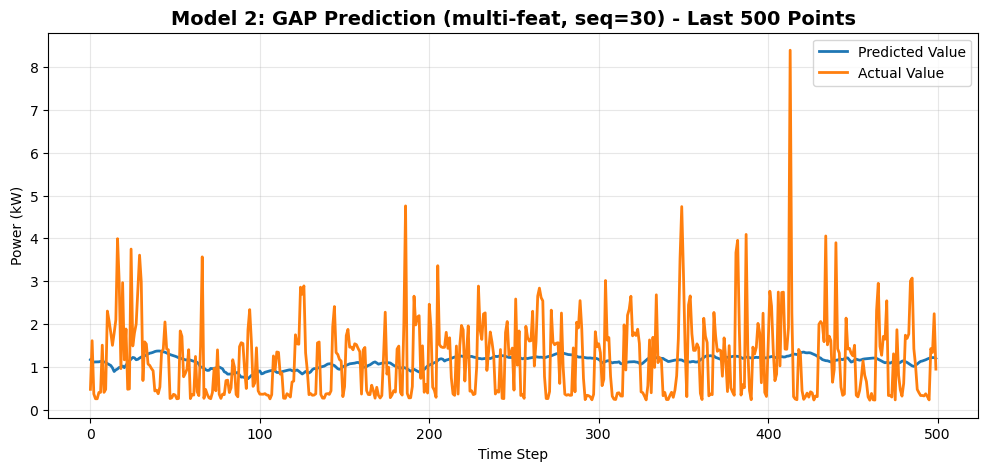


Model 3 (Single Feature, seq=20) Results:
128/128 - 0s - 2ms/step - loss: 0.7941 - mse: 0.7941
MSE: 0.794113
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


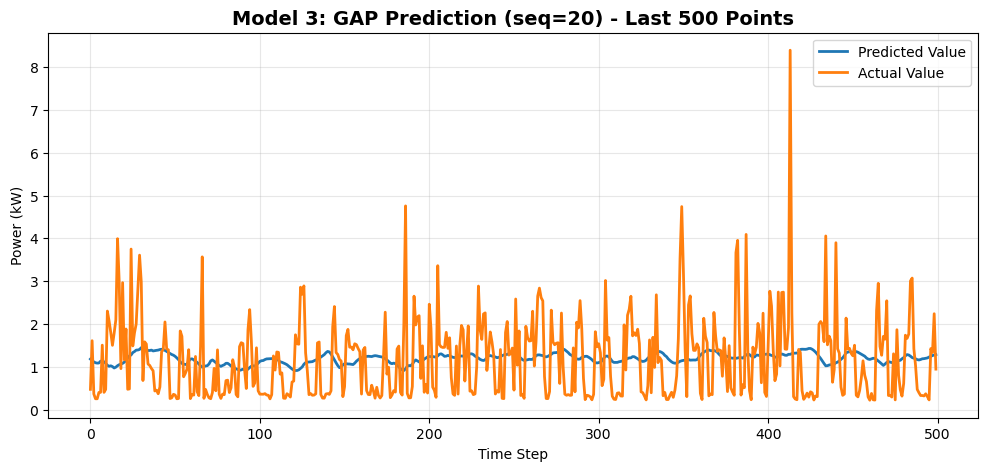


FINAL COMPARISON SUMMARY:
Model 1 (Original, seq=30):     MSE = 0.778298
Model 2 (Multi-feat, seq=30):   MSE = 0.776994
Model 3 (Original, seq=20):     MSE = 0.794113
Model 2 vs Model 1: +0.17%
Model 3 vs Model 1: -2.03%


In [31]:
# Validate and compare all three models on the validation data

# First, create validation arrays for the improved model with multiple features
val_arrays_v2 = []
val_labs_v2 = []

for i in range(1, len(val_df) - ph):
    start_idx = max(0, i - seq_length + 1)
    val_seq = val_df[feat_cols_improved].iloc[start_idx:i+1].values
    
    if i + ph < len(val_df):
        label = val_df["Global_active_power"].iloc[i + ph]
        val_arrays_v2.append(val_seq)
        val_labs_v2.append(label)

val_arrays_v2 = pad_sequences(val_arrays_v2, maxlen = seq_length, padding = "pre", dtype = "float32")
val_labs_v2 = np.array(val_labs_v2, dtype = object).astype(np.float32)

# Create validation arrays for Model 3 (seq_length=20)
val_arrays_v3 = []
val_labs_v3 = []

for i in range(1, len(val_df) - ph_v3):
    start_idx = max(0, i - seq_length_v3 + 1)
    val_seq = val_df[feat_cols_v3].iloc[start_idx:i+1].values
    
    if i + ph_v3 < len(val_df):
        label = val_df['Global_active_power'].iloc[i + ph_v3]
        val_arrays_v3.append(val_seq)
        val_labs_v3.append(label)

val_arrays_v3 = pad_sequences(val_arrays_v3, maxlen=seq_length_v3, padding="pre", dtype="float32")
val_labs_v3 = np.array(val_labs_v3, dtype=object).astype(np.float32)

# Evaluate all three models
print("="*60)
print("Model 1 (Original - Single Feature, seq=30) Results:")
print("="*60)
scores_model1 = model.evaluate(val_arrays, val_labs, verbose = 2)
print(f"MSE: {scores_model1[1]:.6f}")
y_pred_model1 = model.predict(val_arrays)

fig_m1 = plt.figure(figsize = (12, 5))
plt.plot(y_pred_model1[-500:], label = "Predicted Value", linewidth = 2)
plt.plot(y_true_test[-500:], label = "Actual Value", linewidth = 2)
plt.title("Model 1: GAP Prediction (seq=30) - Last 500 Points", fontsize = 14, fontweight = "bold")
plt.ylabel("Power (kW)")
plt.xlabel("Time Step")
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()
fig_m1.savefig("model1_validation.png")

print("\n" + "="*60)
print("Model 2 (Improved - Multiple Features, seq=30) Results:")
print("="*60)
scores_model2 = model_v2.evaluate(val_arrays_v2, val_labs_v2, verbose = 2)
print(f"MSE: {scores_model2[1]:.6f}")
y_pred_model2 = model_v2.predict(val_arrays_v2)

fig_m2 = plt.figure(figsize = (12, 5))
plt.plot(y_pred_model2[-500:], label = "Predicted Value", linewidth = 2)
plt.plot(val_labs_v2[-500:], label = "Actual Value", linewidth = 2)
plt.title("Model 2: GAP Prediction (multi-feat, seq=30) - Last 500 Points", fontsize = 14, fontweight = "bold")
plt.ylabel("Power (kW)")
plt.xlabel("Time Step")
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()
fig_m2.savefig("model2_validation.png")

print("\n" + "="*60)
print("Model 3 (Single Feature, seq=20) Results:")
print("="*60)
scores_model3 = model_v3.evaluate(val_arrays_v3, val_labs_v3, verbose = 2)
print(f"MSE: {scores_model3[1]:.6f}")
y_pred_model3 = model_v3.predict(val_arrays_v3)

fig_m3 = plt.figure(figsize = (12, 5))
plt.plot(y_pred_model3[-500:], label = "Predicted Value", linewidth = 2)
plt.plot(val_labs_v3[-500:], label = "Actual Value", linewidth = 2)
plt.title("Model 3: GAP Prediction (seq=20) - Last 500 Points", fontsize = 14, fontweight = "bold")
plt.ylabel("Power (kW)")
plt.xlabel("Time Step")
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()
fig_m3.savefig("model3_validation.png")

# Summary comparison
print("\n" + "="*60)
print("FINAL COMPARISON SUMMARY:")
print("="*60)
print(f"Model 1 (Original, seq=30):     MSE = {scores_model1[1]:.6f}")
print(f"Model 2 (Multi-feat, seq=30):   MSE = {scores_model2[1]:.6f}")
print(f"Model 3 (Original, seq=20):     MSE = {scores_model3[1]:.6f}")
print("="*60)
imp_m2 = ((scores_model1[1] - scores_model2[1]) / scores_model1[1]) * 100
imp_m3 = ((scores_model1[1] - scores_model3[1]) / scores_model1[1]) * 100
print(f"Model 2 vs Model 1: {imp_m2:+.2f}%")
print(f"Model 3 vs Model 1: {imp_m3:+.2f}%")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: There appears to be little change when adding multiple features, and it performed worse when changing the sequence length to 20. The limited improvement suggests that while additional features and deeper architecture help slightly, they don't dramatically change performance. This took a lot of computational power to perform unfortunately, I have 128 GB of RAM and a 24-core processor and it still took a while to train. I was also surprised at how underfit all 3 models were. It appears all that was accomplished was that I determined the mean, and the models failed to capture the variance. I tried changing sequence length and adding features did not help. I would like to add more data if I was to continue this in the future. 

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: The linear regression model signficantly outperfomred at a MSE of 0.59. The LSTM took significantly longer to train and was far more difficult to interpret, which is especially important for IOTs that could be deployed in a resource constrained environment. I also don't think I trained with adaquate data, and think that if I had more the LSTM would perform a lot better. Due to the simplicity and better performance, I would choose the linear model over the LSTM model. 